# MLFlow Tracking

https://mlflow.org/

## Kaggle Titanic Challange
We use the well-known dataset from Kaggle called Titanic: Machine Learning from Disaster.
The goal of the titanic challenge is to predict if the person died or survived during the disaster.
https://www.kaggle.com/c/titanic

### Basic imports

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

### Helper functions

In [13]:
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title=None,
    cmap=plt.cm.Blues
):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Pull data

In [3]:
RELATIVE_DATA_FOLDER_PATH = './../data'
RELATIVE_TRAIN_DATA_PATH = 'train.csv'
RELATIVE_TEST_DATA_PATH = 'test.csv'

def get_data(relative_data_folder_path, relative_path):
    abs_path = os.path.abspath(os.path.join(relative_data_folder_path, relative_path))
    return pd.read_csv(abs_path, header = 0)

# load data from csv
df_train = get_data(RELATIVE_DATA_FOLDER_PATH, RELATIVE_TRAIN_DATA_PATH)
df_test = get_data(RELATIVE_DATA_FOLDER_PATH, RELATIVE_TEST_DATA_PATH)

### Prepare data for simple experiments

In [4]:
# show data types and NaNs
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
cols_drop = ['Name', 'Cabin', 'Ticket', 'Embarked']

# drop object columns except Sex
df_train = df_train.drop(cols_drop, axis=1).fillna(-1)
df_train = df_train.drop(['PassengerId'], axis=1)
df_test = df_test.drop(cols_drop, axis=1).fillna(-1)
df_test = df_test.drop(['PassengerId'], axis=1)

# change type of Sex column to INT
df_train['Sex'] = df_train['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
df_test['Sex'] = df_test['Sex'].map( {'male': 0, 'female': 1} ).astype(int)

In [6]:
TARGET_LABEL = 'Survived'

X_train = df_train.copy()
y_train = pd.DataFrame()
y_train[TARGET_LABEL] = df_train[TARGET_LABEL]
X_train = X_train.drop([TARGET_LABEL], axis=1)
X_test = df_test.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

### Dataset 

**Feature Dictionary:**<br />
Pclass = Ticket class (1=Upper, 2=Middle, 3=Lower)<br />
Sex = Gender (0=male, 1=female)<br />
Age = Age of current person (-1=NaN)<br />
SibSp = Number of siblings / spouses aboard the Titanic<br />
Parch = Number of parents / children aboard the Titanic<br />
Fare = Passenger fare<br />

**Target Dictionary:**<br />
Survived = If a person survived or not (0=No, 1=Yes)

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 301 to 37
Data columns (total 6 columns):
Pclass    712 non-null int64
Sex       712 non-null int64
Age       712 non-null float64
SibSp     712 non-null int64
Parch     712 non-null int64
Fare      712 non-null float64
dtypes: float64(2), int64(4)
memory usage: 38.9 KB


## Training models

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import sklearn.metrics

import mlflow

Confusion matrix, without normalization


/Users/michal.medek/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


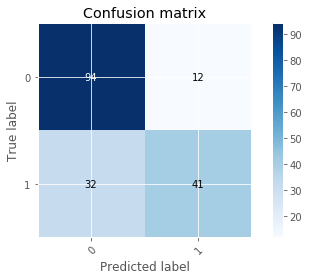

In [56]:
# 'tree', 'xgboost', 'log_regression'
CLASSIFIER_NAME = 'tree'

with mlflow.start_run():
    
    def get_clf(classifier_name):
    
        if classifier_name == 'log_regression':
            random_state = 0
            
            mlflow.log_param('random_state', random_state)
            mlflow.log_param('classifier_name', classifier_name)
            
            return LogisticRegression(random_state=random_state)
        elif classifier_name == 'tree':
            random_state = 0
            max_depth = 10
            
            mlflow.log_param('random_state', random_state)
            mlflow.log_param('max_depth', max_depth)
            mlflow.log_param('classifier_name', classifier_name)
            
            return DecisionTreeClassifier(random_state=random_state, max_depth=max_depth)
        elif classifier_name == 'xgboost':
            max_depth = 5
            
            mlflow.log_param('classifier_name', classifier_name)
            mlflow.log_param('max_depth', max_depth)
            
            return xgb.XGBClassifier(max_depth=5)
    
    # get model    
    clf = get_clf(CLASSIFIER_NAME)

    # fit model
    clf.fit(
        X=X_train,
        y=y_train
    )
    
    # classify validation set
    y_hat = clf.predict(X_val)
    
    # get metrics
    f1_raw = sklearn.metrics.f1_score(y_val, y_hat)
    f1 = round(f1_raw * 100, 2)
    acc = round(sklearn.metrics.accuracy_score(y_val, y_hat) * 100, 2)
    prec = round(sklearn.metrics.precision_score(y_val, y_hat) * 100, 2)
    rec = round(sklearn.metrics.recall_score(y_val, y_hat) * 100, 2)

    # log metrics
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('acc', acc)
    mlflow.log_metric('prec', prec)
    mlflow.log_metric('rec', rec)
    
    # log artifact
    plot_confusion_matrix(y_val, y_hat, classes=[0, 1], 
                          normalize=False, title='Confusion matrix')
    CONF_MATRIX_PATH = 'conf_matrix.png'
    
    plt.savefig(CONF_MATRIX_PATH)
    mlflow.log_artifact(CONF_MATRIX_PATH)
    
    # mlflow.sklearn.log_model(lr, "model")